# Learning a CStree

In [13]:
import os

import numpy as np
import networkx as nx

import cstrees.cstree as ct
import cstrees.stage as st
import cstrees.learning as ctl
import cstrees.scoring as sc

%load_ext autoreload
%autoreload 2
#import sys
#import logging
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the true CStree

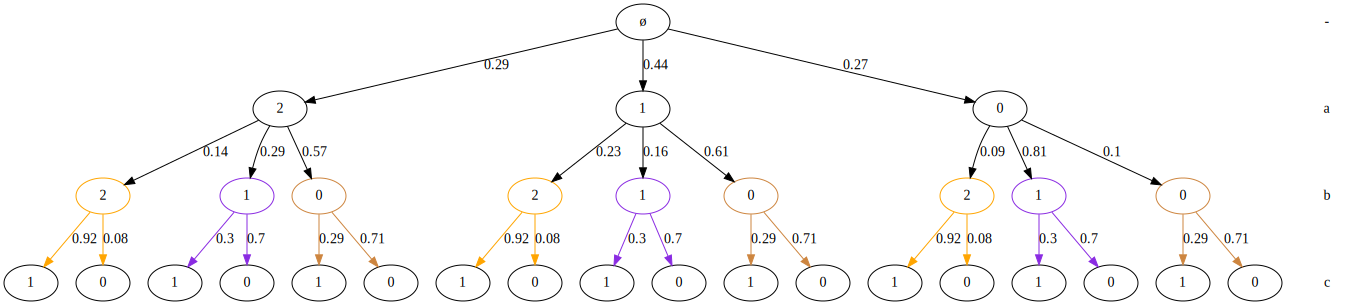

In [14]:
np.random.seed(5)
tree = ct.CStree([3, 3, 2], labels=["a", "b", "c"])

# C _|_ A | B
tree.update_stages({
    0: [{"context": {0: 0}}, {"context": {0: 1}}, {"context": {0: 2}}],
    1: [{"context": {1: 0}}, {"context": {1: 1}}, {"context": {1: 2}}]})

tree.sample_stage_parameters(alpha=1.0)
tree.plot(full=True)

context:  None


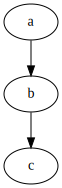

In [15]:
true_cdags = tree.to_minimal_context_graphs()
os.makedirs("testing", exist_ok=True)
for key, val in true_cdags.items():
    print("context: ", key)
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
agraph

## Draw a lot of samples

In [16]:
df = tree.sample(2000)
df

,a,b,c
0,3,3,2
1,1,0,0
2,2,1,1
3,1,2,1
4,0,0,1
...,...,...,...
1996,2,0,0
1997,1,1,0
1998,2,1,0
1999,1,0,1


## Find the optimal order by exhustive search

In [17]:
score_table, context_scores, context_counts = sc.order_score_tables(df,
                                                                    max_cvars=2,
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=None)

Order score tables: 100%|██████████| 3/3 [00:00<00:00, 1289.76it/s]


In [18]:
score_table

{'max_cvars': 2,
 'poss_cvars': {'a': ['b', 'c'], 'b': ['a', 'c'], 'c': ['b', 'a']},
 'scores': {'a': {'None': -2161.513686098569,
   'b': -1833.443392124304,
   'c': -2160.4795057274273,
   'b,c': -1834.5394562178967},
  'b': {'None': -2032.7282393029623,
   'a': -1704.6579453286968,
   'c': -1778.1794994378017,
   'a,c': -1476.2757329466908},
  'c': {'None': -1324.623350425338,
   'b': -1070.0746105601772,
   'a': -1323.589170054196,
   'a,b': -1071.4583567262218}}}

In [19]:
optord, score = ctl._find_optimal_order(score_table)
print("optimal order: {}, score {}".format(optord, score))

optimal order: ['b', 'c', 'a'], score -4937.342306081036


## Find the optimal CStree (staging of each level) of the best order

In [20]:
opttree = ctl._optimal_cstree_given_order(optord, context_scores)
print("Optimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)

Optimal CStree stagings per level:
level 0:
[0]
[1]
[2]
level 1:
[0, {0, 1}]
[1, {0, 1}]
[2, {0, 1}]
level 2:


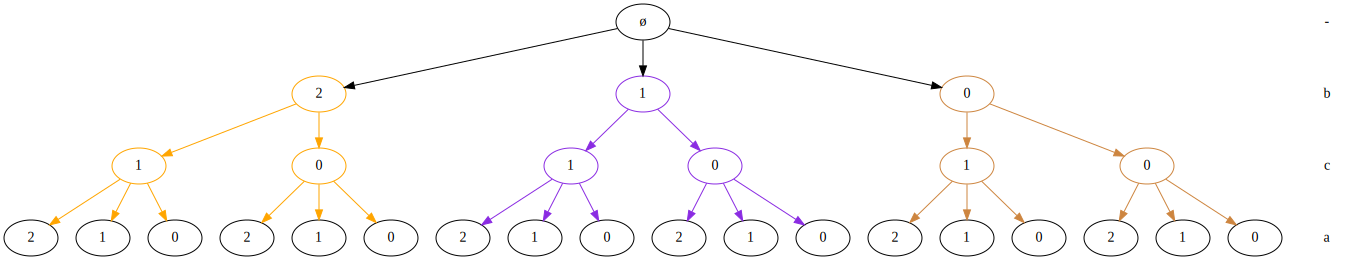

In [21]:
opttree.plot(full=True)

## Estimate the parameters

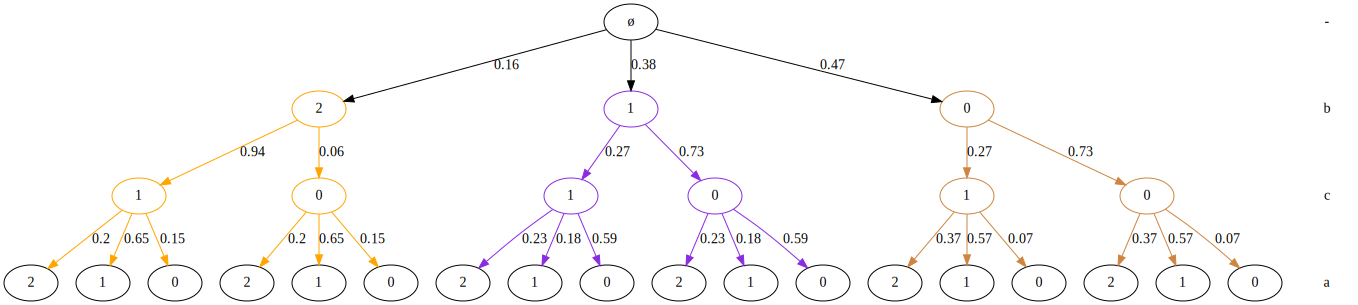

In [22]:
opttree.estimate_stage_parameters(df, alpha_tot=1.0, method="BDeu")
opttree.plot(full=True)

## Plot the minimal context DAGs

Number of contexts: 1
Context: None


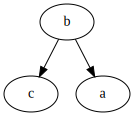

In [23]:
opt_cdags = opttree.to_minimal_context_graphs()
print("Number of contexts: {}".format(len(opt_cdags)))
for key, val in opt_cdags.items():
    print("Context: {}".format(key))
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
agraph